In [1]:
# Libraries used 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.colors as mcolors
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, classification_report
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping
from math import sqrt

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


2023-11-30 14:11:05.794519: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Upload the file 
Mdata = pd.read_csv('cleaned_earthquake_data.csv')

In [3]:
# display the data
Mdata

,date,time,latitude,longitude,depth,mag,year,month,day,hour,minute,second,DateTime
0,1901-04-24,15:45:00,36.8300,-7.6700,0.0,0.0,1901,4,24,15,45,0,1901-04-24 15:45:00
1,1901-05-25,03:25:00,36.7000,-3.5000,0.0,5.0,1901,5,25,3,25,0,1901-05-25 03:25:00
2,1901-12-10,00:00:00,36.4200,-5.2400,0.0,5.0,1901,12,10,0,0,0,1901-12-10 00:00:00
3,1902-05-01,12:38:00,35.2000,-4.1000,0.0,4.2,1902,5,1,12,38,0,1902-05-01 12:38:00
4,1902-06-16,13:30:00,35.3000,-3.0000,0.0,0.0,1902,6,16,13,30,0,1902-06-16 13:30:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
65926,2023-10-22,17:25:29,30.9445,-8.2348,5.0,2.4,2023,10,0,17,25,29,2023-10-22 17:25:29
65927,2023-10-22,18:17:38,30.8476,-8.2992,8.0,1.8,2023,10,0,18,17,38,2023-10-22 18:17:38
65928,2023-10-22,20:17:02,31.0007,-8.2507,6.5,1.6,2023,10,0,20,17,2,2023-10-22 20:17:02
65929,2023-10-22,21:48:25,30.9604,-8.3697,7.0,1.8,2023,10,0,21,48,25,2023-10-22 21:48:25


In [4]:
# Convert 'DateTime' column to datetime dtype
Mdata['DateTime'] = pd.to_datetime(Mdata['DateTime'])

In [5]:
# create a table of the main characteristics
table = ['DateTime', 'mag', 'longitude','latitude','depth', 'year']

In [6]:
# Sort the top 5 earthquakes (magnitude)
Mdata.sort_values('mag', ascending=False)[table].head(5)

,DateTime,mag,longitude,latitude,depth,year
1901,1969-02-28 02:40:32,7.3,-10.5700,36.0100,22.0,1969
62694,2023-09-08 22:11:00,7.0,-8.4437,30.9959,9.4,2023
751,1954-03-29 06:18:05,7.0,-3.6000,37.0000,657.0,1954
4885,1975-05-26 09:11:51,6.7,-17.5600,35.9800,34.0,1975
139,1915-07-11 11:28:06,6.6,-10.5000,37.0000,50.0,1915


In [7]:
# Sort the top 5 earthquakes (depth)
Mdata.sort_values('depth', ascending=False)[table].head(5)

,DateTime,mag,longitude,latitude,depth,year
31211,2019-02-25 15:45:59,2.1,-6.164,32.619,11010.7,2019
31257,2019-03-01 23:57:24,1.7,-5.385,36.797,11010.5,2019
32881,2019-10-16 02:49:53,1.0,-1.513,35.080,1410.4,2019
32373,2019-08-16 14:36:55,2.5,-8.020,36.143,1410.3,2019
32703,2019-09-26 12:44:47,0.9,-5.764,31.655,1410.1,2019


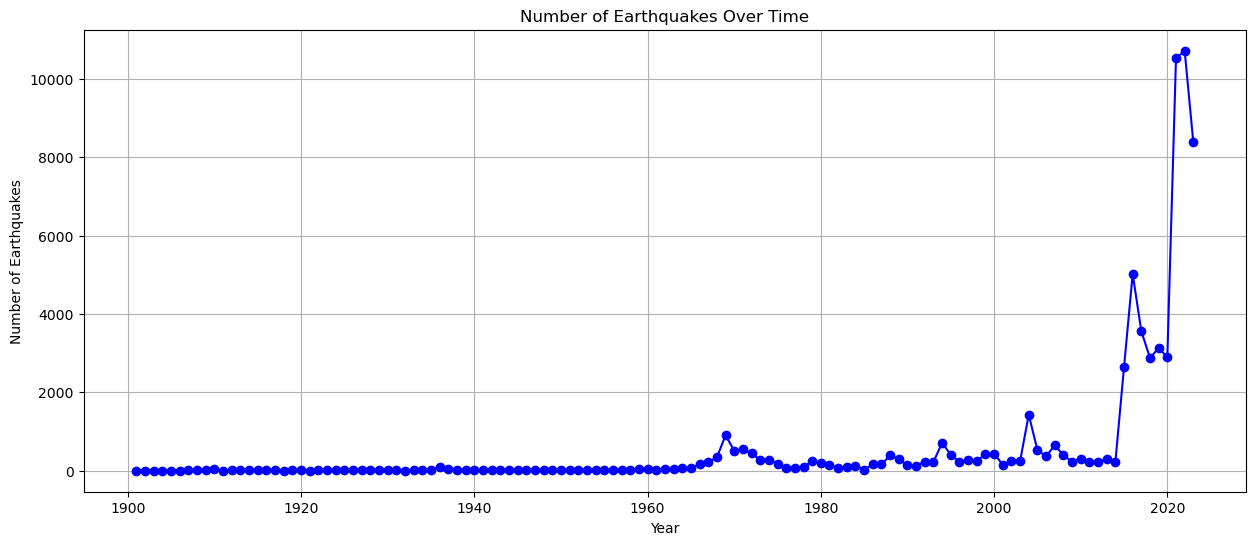

In [8]:
# Filtering the data to include only years up to 2023
Mdata = Mdata[Mdata['DateTime'].dt.year <= 2023]

# PlotNumber of Earthquakes Over Time
plt.figure(figsize=(15, 6))
Mdata.groupby(Mdata['DateTime'].dt.year).size().plot(kind='line', color='blue', marker='o')
plt.title('Number of Earthquakes Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Earthquakes')
plt.grid(True)
plt.show()

<Figure size 1500x600 with 0 Axes>

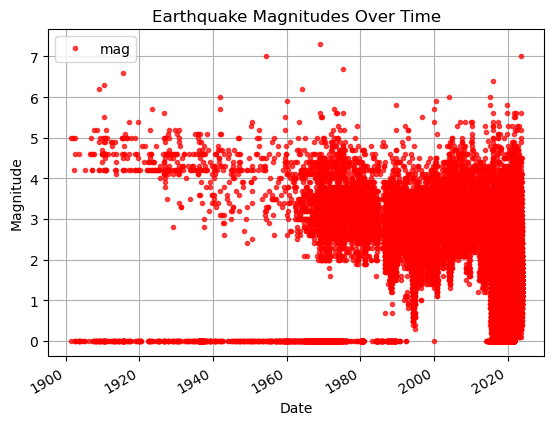

In [9]:
# Filtering out records with negative magnitudes
Mdata = Mdata[Mdata['mag'] >= 0]

# plot of Earthquake Magnitudes Over Time
plt.figure(figsize=(15, 6))
Mdata.plot(kind='line', x='DateTime', y='mag', color='red', marker='.', linestyle='None', alpha=0.7)
plt.title('Earthquake Magnitudes Over Time')
plt.xlabel('Date')
plt.ylabel('Magnitude')
plt.grid(True)
plt.show()


In [10]:
# Filtering the data for valid longitude and latitude values
Mdata = Mdata[(Mdata['longitude'].between(-180, 180)) & (Mdata['latitude'].between(-90, 90))]

In [11]:
# Converting the DataFrame to a GeoDataFrame
geometry = [Point(xy) for xy in zip(Mdata['longitude'], Mdata['latitude'])]
gdf = gpd.GeoDataFrame(Mdata, geometry=geometry)

In [12]:
# Loading world map for the background
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

/var/folders/qm/6z6hsdq958b5_5kw6ns781xr0000gn/T/ipykernel_99947/1485888388.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


In [13]:
# Converting the central coordinates to decimal degrees
central_latitude = 31 + 47/60 + 40.29/3600
central_longitude = -(7 + 5/60 + 5.76/3600)

# Expanding the range to reduce the zoom level
expanded_longitude_range = 11  # 11 degrees on either side of the central longitude
expanded_latitude_range = 14  # 14 degrees on either side of the central latitude

# Calculating the expanded bounds
expanded_min_lon = central_longitude - expanded_longitude_range
expanded_max_lon = central_longitude + expanded_longitude_range
expanded_min_lat = central_latitude - expanded_latitude_range
expanded_max_lat = central_latitude + expanded_latitude_range

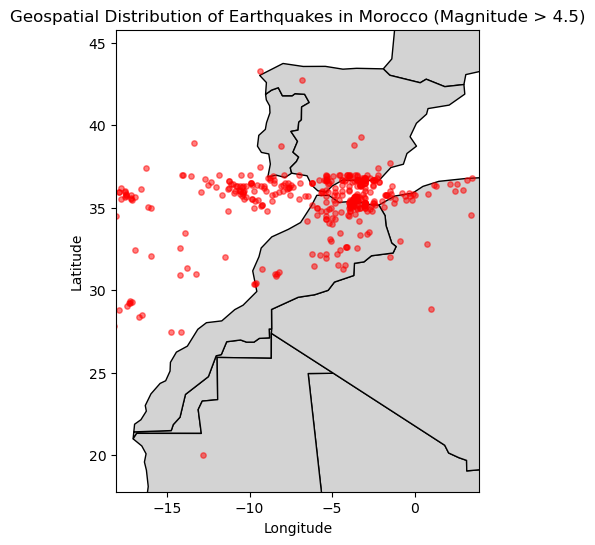

In [14]:
# Filtering the GeoDataFrame to include only earthquakes with magnitude higher than 4.5
gdf_high_magnitude = gdf[gdf['mag'] > 4.5]

# Plotting the geospatial distribution focused on earthquakes with magnitude higher than 4.5
fig, ax = plt.subplots(figsize=(10, 6))
world.plot(ax=ax, color='lightgrey', edgecolor='black')
gdf_high_magnitude.plot(ax=ax, marker='o', color='red', markersize=15, alpha=0.5)
ax.set_title('Geospatial Distribution of Earthquakes in Morocco (Magnitude > 4.5)')
ax.set_xlim(expanded_min_lon, expanded_max_lon)
ax.set_ylim(expanded_min_lat, expanded_max_lat)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


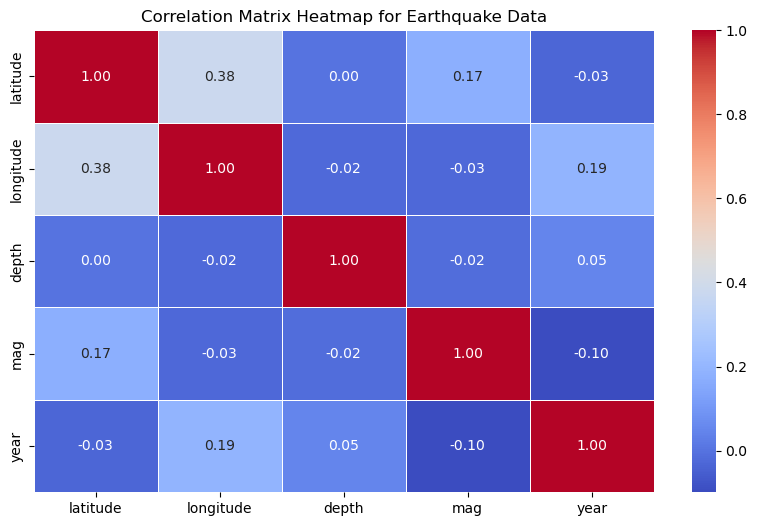

In [15]:
# Correlation Analysis - Heatmap

# Selecting relevant columns for correlation analysis (excluding non-numeric and redundant columns)
columns_for_correlation = ['latitude', 'longitude', 'depth', 'mag', 'year']
correlation_data = Mdata[columns_for_correlation]

# Calculating the correlation matrix
correlation_matrix = correlation_data.corr()

# Plotting the heatmap for the correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix Heatmap for Earthquake Data')
plt.show()


In [16]:
# Filtering out outliers in depth (removing values greater than 2000)
Mdata = Mdata[Mdata['depth'] <= 2000]

In [17]:
# Preparing the dataset for machine learning
# For KNN, we will categorize the magnitudes into classes (e.g., 0-1, 1-2, etc.)
df_ml = Mdata.copy()
df_ml['mag_category'] = pd.cut(df_ml['mag'], bins=np.arange(0, 10, 1), labels=np.arange(0, 9, 1))

In [18]:
# Selecting features and target variable
features = ['latitude', 'longitude', 'depth', 'year', 'month', 'day', 'hour', 'minute', 'second']
target_knn = 'mag_category'
target_rf = 'mag'

In [21]:
# Splitting the data into training and testing sets
X_train_knn, X_test_knn, y_train_knn, y_test_knn = train_test_split(df_ml[features], df_ml[target_knn], test_size=0.2, random_state=42)
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(df_ml[features], df_ml[target_rf], test_size=0.2, random_state=42)

In [22]:
# Remove rows where the target variable is NaN
train_data = pd.concat([X_train_knn, y_train_knn], axis=1)
train_data = train_data.dropna(subset=['mag_category'])  # Replace 'target_column_name' with the actual name

# Split the data back into features and target variable
X_train_knn = train_data.drop(['mag_category'], axis=1)
y_train_knn = train_data['mag_category']

In [23]:
# Standardizing the features
scaler = StandardScaler()
X_train_knn = scaler.fit_transform(X_train_knn)
X_test_knn = scaler.transform(X_test_knn)
X_train_rf = scaler.fit_transform(X_train_rf)
X_test_rf = scaler.transform(X_test_rf)

In [24]:
# Remove rows in the test set where the target variable is NaN
X_test_knn = X_test_knn[y_test_knn.notna()]
y_test_knn = y_test_knn[y_test_knn.notna()]

In [25]:
# K-Nearest Neighbors Classifier
knn = KNeighborsClassifier()
knn.fit(X_train_knn, y_train_knn)
knn_predictions = knn.predict(X_test_knn)
knn_accuracy = classification_report(y_test_knn, knn_predictions)

/Users/rahma/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rahma/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rahma/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, m

In [26]:
# Random Forest Regressor
rf = RandomForestRegressor()
rf.fit(X_train_rf, y_train_rf)
rf_predictions = rf.predict(X_test_rf)

In [27]:
# Evaluating the models
knn_accuracy = classification_report(y_test_knn, knn_predictions)
rf_rmse = sqrt(mean_squared_error(y_test_rf, rf_predictions))

/Users/rahma/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rahma/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rahma/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, m

In [28]:
print(knn_accuracy)
print(rf_rmse)

              precision    recall  f1-score   support

           0       0.22      0.11      0.14       760
           1       0.70      0.88      0.78      6353
           2       0.48      0.39      0.43      2840
           3       0.55      0.30      0.39      1308
           4       0.69      0.29      0.41       218
           5       0.00      0.00      0.00        19
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         1

    accuracy                           0.63     11500
   macro avg       0.33      0.25      0.27     11500
weighted avg       0.59      0.63      0.60     11500

0.7134462344437823


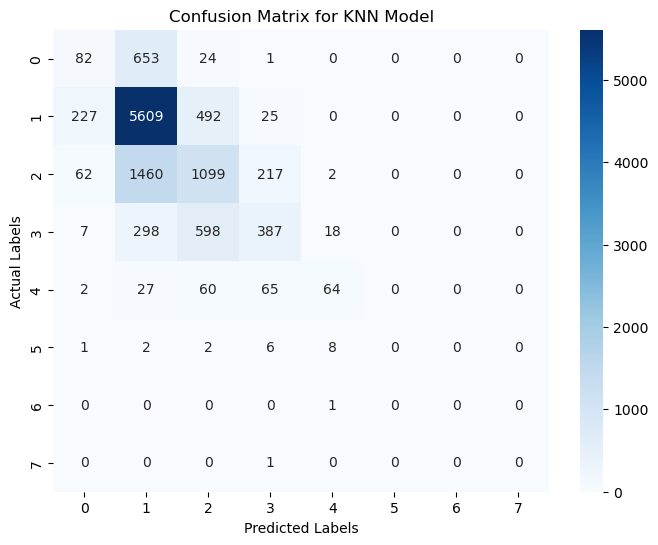

In [29]:
# Adjusting the confusion matrix to match the actual classes in the test data
unique_classes = sorted(y_test_knn.unique())
cm = confusion_matrix(y_test_knn, knn_predictions, labels=unique_classes)
cm_df = pd.DataFrame(cm, index=unique_classes, columns=unique_classes)

# Plotting the adjusted confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix for KNN Model')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()

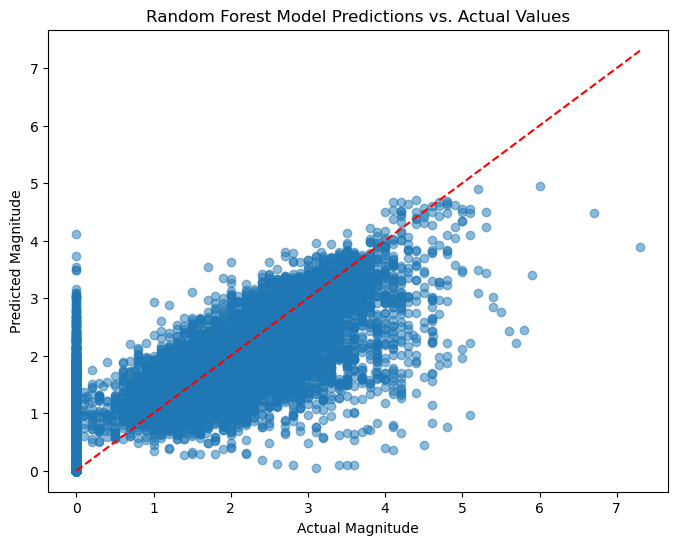

In [30]:
#Plot Random forest results 
plt.figure(figsize=(8, 6))
plt.scatter(y_test_rf, rf_predictions, alpha=0.5)
plt.plot([min(y_test_rf), max(y_test_rf)], [min(y_test_rf), max(y_test_rf)], 'r--')
plt.title('Random Forest Model Predictions vs. Actual Values')
plt.xlabel('Actual Magnitude')
plt.ylabel('Predicted Magnitude')
plt.show()

In [31]:
# Hyperparameter tuning for KNN
knn_params = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

knn_grid = GridSearchCV(KNeighborsClassifier(), knn_params, cv=5, scoring='accuracy')
knn_grid.fit(X_train_knn, y_train_knn)

best_knn_params = knn_grid.best_params_
best_knn_score = knn_grid.best_score_

In [32]:
print(best_knn_params)
print(best_knn_score)

{'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'distance'}
0.6594801294560994


In [33]:
# Hyperparameter tuning for Random Forest
rf_params = {
    'n_estimators': [50, 100, 150],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

rf_grid = GridSearchCV(RandomForestRegressor(), rf_params, cv=5, scoring='neg_mean_squared_error')
rf_grid.fit(X_train_rf, y_train_rf)

best_rf_params = rf_grid.best_params_
best_rf_score = rf_grid.best_score_

In [35]:
print(best_rf_params)
print(-best_rf_score)

{'max_depth': 20, 'min_samples_split': 10, 'n_estimators': 150}
0.511665409790864


In [36]:
# Preprocessing for time series model
# Using only DateTime and magnitude for these models
# Aggregating and resampling the data
ts_df = Mdata[['DateTime', 'mag']].set_index('DateTime').resample('D').mean()
ts_df.fillna(method='ffill', inplace=True)

/var/folders/qm/6z6hsdq958b5_5kw6ns781xr0000gn/T/ipykernel_99947/3072310089.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ts_df.fillna(method='ffill', inplace=True)


In [37]:
# Splitting the data into training and testing sets for time series model
train_size = int(len(ts_df) * 0.8)
train, test = ts_df[0:train_size], ts_df[train_size:len(ts_df)]

In [38]:
# LSTM model
# Preparing data for LSTM
train_lstm = np.array(train).reshape(-1, 1)
test_lstm = np.array(test).reshape(-1, 1)

In [39]:
# Feature Scaling for LSTM
scaler = StandardScaler()
train_lstm_scaled = scaler.fit_transform(train_lstm)
test_lstm_scaled = scaler.transform(test_lstm)

In [40]:
# Reshaping data for LSTM
def create_dataset(dataset, time_step=1):
    X, y = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        X.append(a)
        y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 100
X_train, y_train = create_dataset(train_lstm_scaled, time_step)
X_test, y_test = create_dataset(test_lstm_scaled, time_step)

In [41]:
# Reshape input to be [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [42]:
# LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(50, return_sequences=True, input_shape=(100,1)))
lstm_model.add(LSTM(50, return_sequences=False))
lstm_model.add(Dense(1))

lstm_model.compile(optimizer='adam', loss='mean_squared_error')
early_stop = EarlyStopping(monitor='loss', patience=10, verbose=1)
lstm_model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=1, callbacks=[early_stop])

lstm_predictions_scaled = lstm_model.predict(X_test)
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)
lstm_rmse = sqrt(mean_squared_error(y_test, lstm_predictions[:,0]))

2023-11-30 15:36:47.909492: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-30 15:36:47.911467: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-30 15:36:47.912152: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/100


2023-11-30 15:36:48.666392: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-30 15:36:48.667686: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-30 15:36:48.668482: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

558/558 [==============================] - 44s 74ms/step - loss: 0.1465
Epoch 2/100
558/558 [==============================] - 40s 71ms/step - loss: 0.1139
Epoch 3/100
558/558 [==============================] - 38s 69ms/step - loss: 0.1123
Epoch 4/100
558/558 [==============================] - 39s 69ms/step - loss: 0.1112
Epoch 5/100
558/558 [==============================] - 41s 74ms/step - loss: 0.1105
Epoch 6/100
558/558 [==============================] - 39s 70ms/step - loss: 0.1105
Epoch 7/100
558/558 [==============================] - 41s 74ms/step - loss: 0.1105
Epoch 8/100
558/558 [==============================] - 41s 73ms/step - loss: 0.1096
Epoch 9/100
558/558 [==============================] - 40s 72ms/step - loss: 0.1094
Epoch 10/100
558/558 [==============================] - 41s 73ms/step - loss: 0.1088
Epoch 11/100
558/558 [==============================] - 39s 70ms/step - loss: 0.1084
Epoch 12/100
558/558 [==============================] - 43s 78ms/step - loss: 0.1088
E

2023-11-30 16:54:52.678717: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-30 16:54:52.680115: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-30 16:54:52.680786: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

277/277 [==============================] - 6s 15ms/step


In [43]:
print(lstm_rmse)

2.3950746757114154


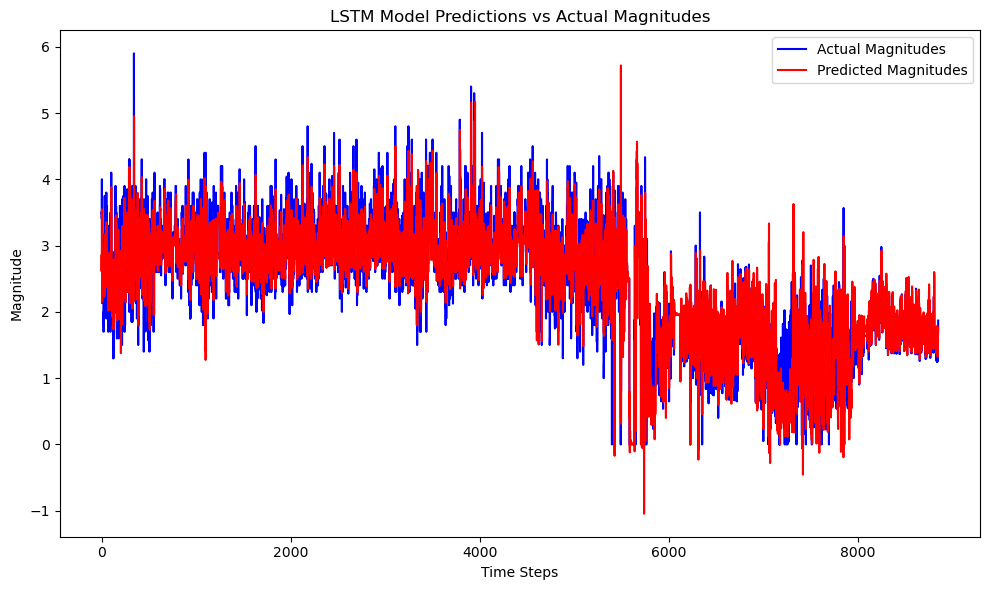

In [44]:
# Assuming y_test and lstm_predictions are the true values and LSTM model predictions respectively.
# Since y_test is scaled, it needs to be inverted to compare with the original magnitudes.
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate RMSE for the rescaled test data.
lstm_rmse_rescaled = sqrt(mean_squared_error(y_test_rescaled, lstm_predictions))

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(y_test_rescaled, label='Actual Magnitudes', color='blue')
plt.plot(lstm_predictions, label='Predicted Magnitudes', color='red')
plt.title('LSTM Model Predictions vs Actual Magnitudes')
plt.xlabel('Time Steps')
plt.ylabel('Magnitude')
plt.legend()
plt.tight_layout()
plt.show()